## Case study to identify the factors for loan defaults based on the historic data.
#### This will be useful to identify the loan applications which needs to be rejected.

#### Key findings 
- Loans taken for the purpose of 'Small Business' and 'Renewable Energy' have a higer rate of default.
- Nebraska 'NE' has a very high default rate of 60%
- Longer Loan terms have a higher rate of default. Loan of 60 months have a default rate of 25%
- Loans of Grade 'D','E','F' and 'G' have a very high default rate when compared to others. 
- Sub Grades - F5 and G3 have the highest default rates 
- People with Higher number of Bankruptcies are more likely to default. 
- Default rates decrease as the annual income increases. This is observed till the income level of  500K USD.
- Default rates increases as the DTI levels increase.
- For the loan grade 'G', the deualt rate is higher for shorter term loans. This is opposite to the observations across other loan grades.

In [1]:
## Load the data into a dataframe
import numpy as np
import pandas as pd
low_memory=False
df_master = pd.read_csv("loan.csv" ,encoding='ISO-8859-1', low_memory=False)

In [2]:
df_master.shape

(39717, 111)

### Step 1 - Identify the rows and columns which need to be cleaned ,add header to relevant columns and fix the mis aligned rows
 - The shape of the data is consistent so it does not appear to have a misaligned rows
 - The headers look fine and hence no change is needed 
 - Remove the rows with all null values
 - Create new columns for Term months and employment length seperating the text from the numerical values

In [3]:
# remove all the null rows
df_master.dropna(how='all' ,inplace=True)

# drop duplicate rows 
df_master.drop_duplicates(keep='last')

# identify the columns which have lot of NA
df_master.dropna(axis=1 ,how='all' ,inplace = True)
#Remove columns which have 90% or above null data. A column having more than 90% null values may not be useful
# in the anlysis
df_master.dropna (axis=1, thresh=round(df_master.shape[0] * 0.7) ,inplace=True ) 

#Remove rows which have more than 10% null values from the existing dataframe
df_master.dropna(how='all' ,thresh=round(df_master.shape[1] * 0.9) ,inplace=True)

In [4]:
df_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39717 entries, 0 to 39716
Data columns (total 53 columns):
id                            39717 non-null int64
member_id                     39717 non-null int64
loan_amnt                     39717 non-null int64
funded_amnt                   39717 non-null int64
funded_amnt_inv               39717 non-null float64
term                          39717 non-null object
int_rate                      39717 non-null object
installment                   39717 non-null float64
grade                         39717 non-null object
sub_grade                     39717 non-null object
emp_title                     37258 non-null object
emp_length                    38642 non-null object
home_ownership                39717 non-null object
annual_inc                    39717 non-null float64
verification_status           39717 non-null object
issue_d                       39717 non-null object
loan_status                   39717 non-null object
pymnt_pl

In [5]:
#create  new column which will hold the years of experience with the text years.
# eg 10+ will be treaded as 10 etc.

df_master['emp_years'] = df_master['emp_length'].str.slice(0,-5).str.strip()
df_master['emp_years'] = df_master['emp_years'].str.replace('+', '')
df_master['emp_years'] = df_master['emp_years'].str.replace('<', '')
df_master['emp_years'] = df_master['emp_years'].str.replace('', '')
df_master['emp_years'] = pd.to_numeric(df_master['emp_years'])

In [6]:
#create a new column to hold the numerical values for the col - 'term'
df_master['loan_term'] = df_master['term'].str.slice(0,-7).str.strip()
df_master['loan_term'] = pd.to_numeric(df_master['loan_term'])

In [7]:
#Hold the percentage numeric value for 'revol_util'
df_master['revol_util_numeric'] = df_master['revol_util'].str.slice(0,-1).str.strip()
df_master['revol_util_numeric'] = pd.to_numeric(df_master['revol_util_numeric'])

In [8]:
#Hold the numeric value for 'int_rate'
df_master['int_rate_numeric'] = df_master['int_rate'].str.strip().str.slice(0,-1)
df_master['int_rate_numeric'] = pd.to_numeric(df_master['int_rate_numeric'])

#### Fields which have some data missing are - emp_title ,emp_length ,title ,revol_util, last_pymnt_d, last_credit_pull_d, collections_12_mths_ex_med, chargeoff_within_12_mths, pub_rec_bankruptcies

Out of these emp_length and revol_util can be useful in the analysis and hecne we can impute the data for these

In [9]:
print ("Emp years Mean - {}".format(round(df_master['emp_years'].mean())))
print ("Emp years Median - {}".format(round(df_master['emp_years'].median())))

Emp years Mean - 5
Emp years Median - 4


In [10]:
print ("Revoling credit util Mean - {}".format(round(df_master['revol_util_numeric'].mean())))
print ("Revoling credit util Median - {}".format(round(df_master['revol_util_numeric'].median())))

Revoling credit util Mean - 49
Revoling credit util Median - 49


As per the above analysis , median and mean for the fields values are similar.These fields dont have too many outliers and hence mean can be chosen to impute the values for both the column

### Start the data analysis

In [11]:
#remove the records with the value as 'current' for the column 'loan_status' since these records will not add to the analysis
df_master = df_master[df_master["loan_status"] != "Current"]

In [12]:
#convert the loan_status column to integer 1 or 0 based on the status
df_master["loan_status"] = df_master["loan_status"].apply(lambda x:1 if x == 'Fully Paid' else 0)

In [13]:
# function defined to plot the univariate analysis
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams


def plot_bar_cust (x_data ,y_data,ylabel ,title,xlabel,xticks_rotation = 0 ,text_rotation = 0):
    rcParams['figure.figsize'] = 15, 7
    bars = plt.bar( x_data, y_data, align='center', alpha=1)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.xticks(rotation=xticks_rotation)

    for bar in bars:
        ht = bar.get_height()
        plt.text(bar.get_x(), ht + .005, ht,rotation=text_rotation)
    
    plt.show()

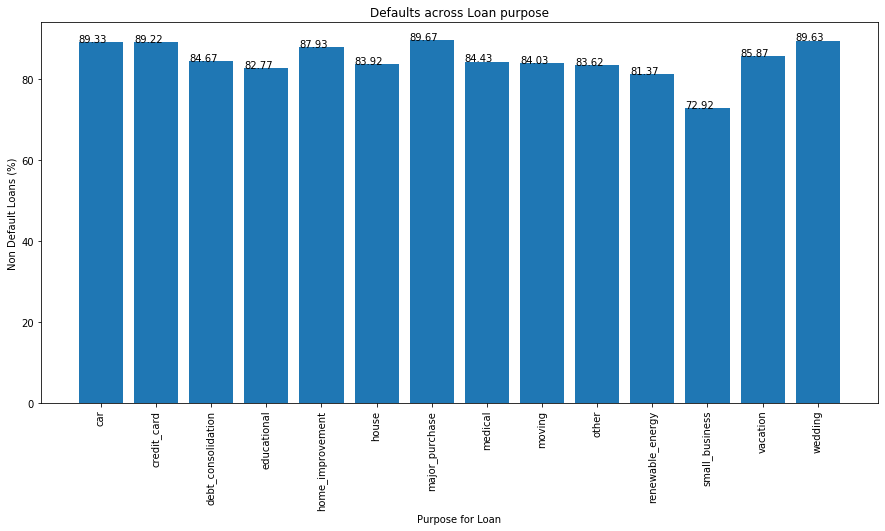

In [14]:
#Data anaysis for some categorical  variables such as purpose of the loan

df_master_grp = df_master.groupby("purpose")
x_val = df_master["purpose"].unique()
x_val.sort()

y_val = round(df_master_grp["loan_status"].sum() / df_master_grp["loan_status"].count() * 100,2)

plot_bar_cust (x_val ,y_val,'Non Default Loans (%)' \
               ,'Defaults across Loan purpose' \
               ,'Purpose for Loan',90)



### Loans taken for 'Small business' have a higher rate of default when compared to other loans

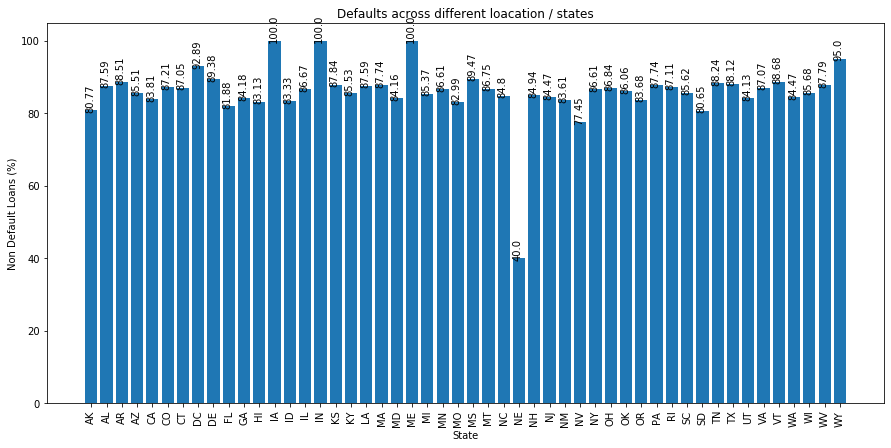

In [15]:
#Data anaysis for some categorical  variables such as purpose of the loan
df_master_grp = df_master.groupby("addr_state")
x_val = df_master["addr_state"].unique()
x_val.sort()

y_val = round(df_master_grp["loan_status"].sum() / df_master_grp["loan_status"].count()*100,2)

plot_bar_cust (x_val ,y_val,'Non Default Loans (%)' \
               ,'Defaults across different loacation / states' \
               ,'State',90,90)



### Loans in the location 'NE' has a very high rate of default

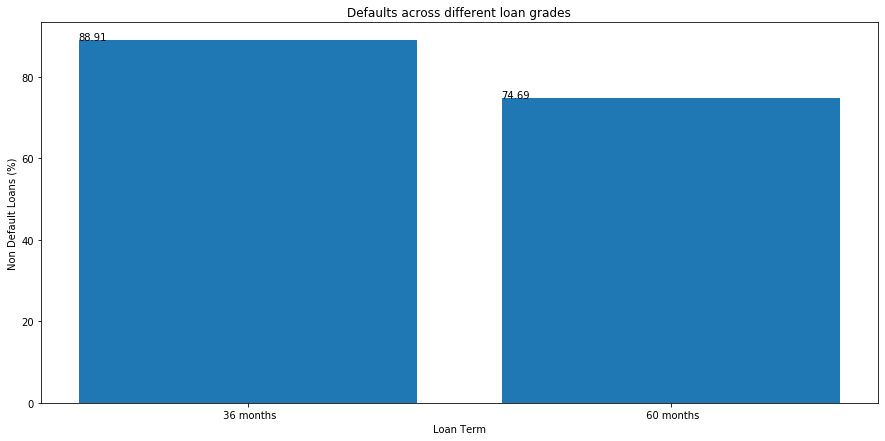

In [16]:
#Data anaysis for some demographic variables such as age, occupation , employment details

df_master_grp = df_master.groupby("term")
x_val = df_master["term"].unique()
x_val.sort()

y_val = round(df_master_grp["loan_status"].sum() / df_master_grp["loan_status"].count() * 100,2)

plot_bar_cust (x_val ,y_val,'Non Default Loans (%)' \
               ,'Defaults across different loan grades' \
               ,'Loan Term',0)

### Higher Loan term of 60 months has a higer default rate

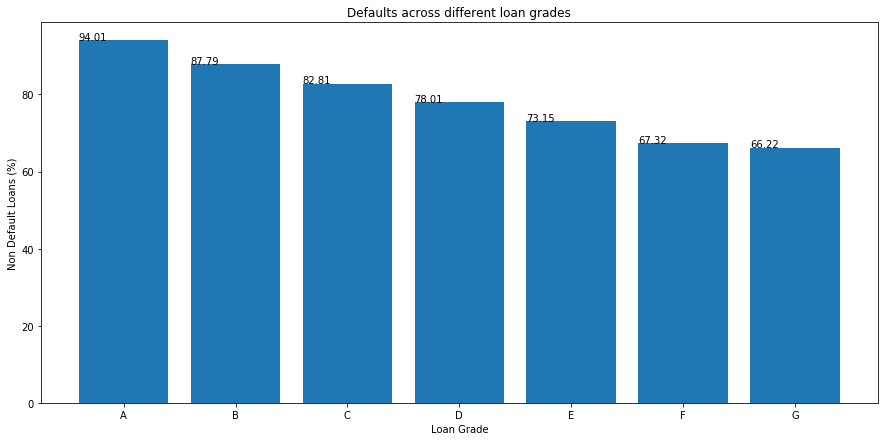

In [17]:
#Data anaysis for 'grade'

df_master_grp = df_master.groupby("grade")
x_val = df_master["grade"].unique()
x_val.sort()

y_val = round(df_master_grp["loan_status"].sum() / df_master_grp["loan_status"].count() * 100,2)

plot_bar_cust (x_val ,y_val,'Non Default Loans (%)' \
               ,'Defaults across different loan grades' \
               ,'Loan Grade',0)


### Loans of Grade type as D,E,F and G have a very high default rate when compared to others. F5 and G3 have the highest default rates 

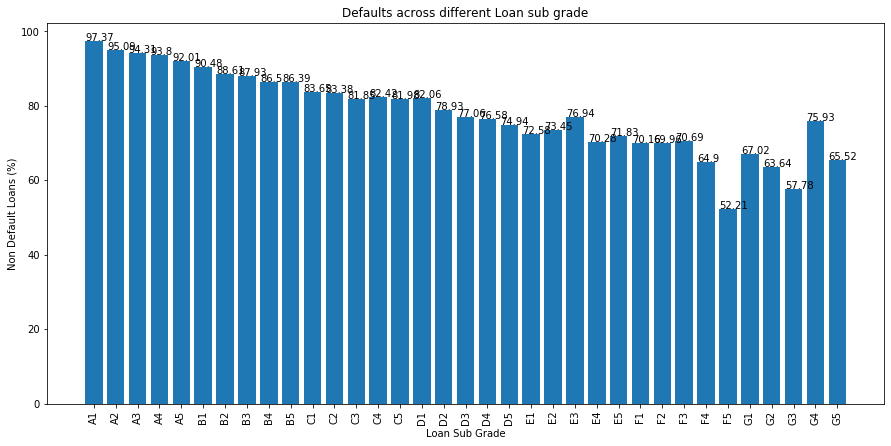

In [18]:
#Data anaysis for some categorical variables such as sub_grade 

df_master_grp = df_master.groupby("sub_grade")
x_val = df_master["sub_grade"].unique()
x_val.sort()

y_val = round(df_master_grp["loan_status"].sum() / df_master_grp["loan_status"].count() * 100,2)
#print (x_val)
#print (y_val)
plot_bar_cust (x_val ,y_val,'Non Default Loans (%)' \
               ,'Defaults across different Loan sub grade' \
               ,'Loan Sub Grade',90)

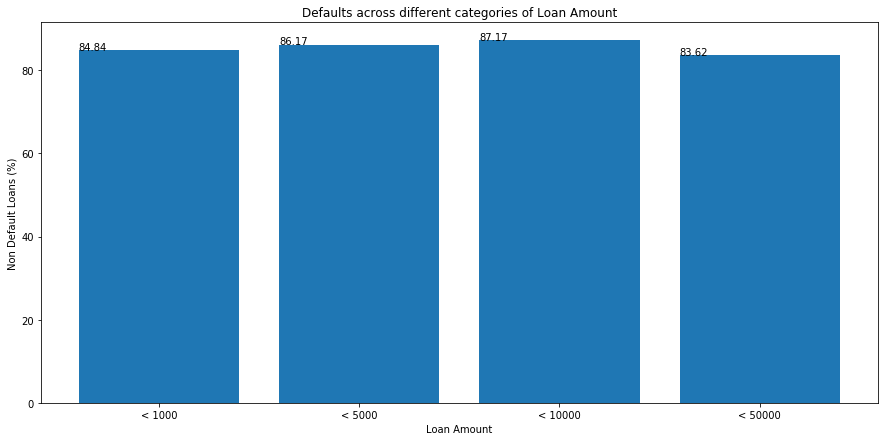

In [19]:
# Binning the categorical contineous data - 'loan amount'
loan_amt_bins = [0, 1000, 5000, 10000, 50000]
bin_labels = ['< 1000','< 5000','< 10000','< 50000']
df_master['loan_amt_binned'] = pd.cut(df_master['loan_amnt'], bins=loan_amt_bins ,labels=bin_labels)

df_master_grp = df_master.groupby("loan_amt_binned")

y_val = round(df_master_grp["loan_status"].sum() / df_master_grp["loan_status"].count() * 100,2)

plot_bar_cust (bin_labels ,y_val,'Non Default Loans (%)' \
               ,'Defaults across different categories of Loan Amount' \
               ,'Loan Amount')

#### There is no impact of the loan amount on the Loan Default rate.

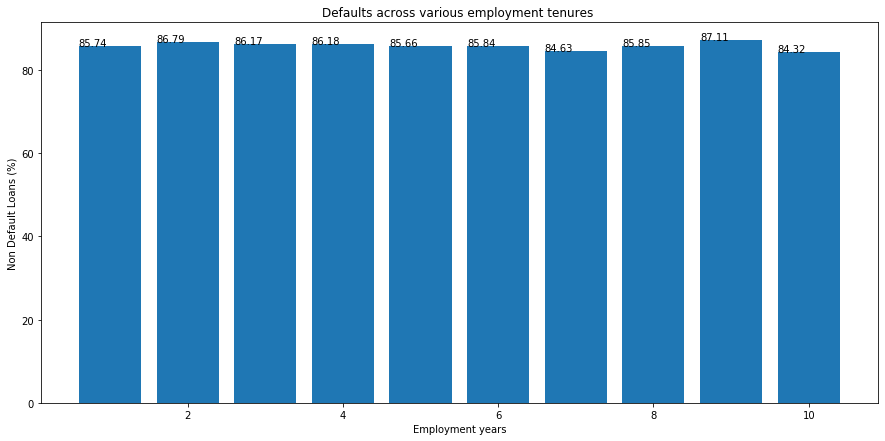

In [20]:
#Data anaysis for some categorical variables such as emp_years

df_master_grp = df_master.groupby("emp_years")
x_val = df_master["emp_years"].unique()
x_val.sort()

y_val = round(df_master_grp["loan_status"].sum() / df_master_grp["loan_status"].count() * 100,2)

plot_bar_cust (x_val[:-1] ,y_val,'Non Default Loans (%)' \
               ,'Defaults across various employment tenures ' \
               ,'Employment years',0)


#### There is no impact of the employment length on the default rate. 

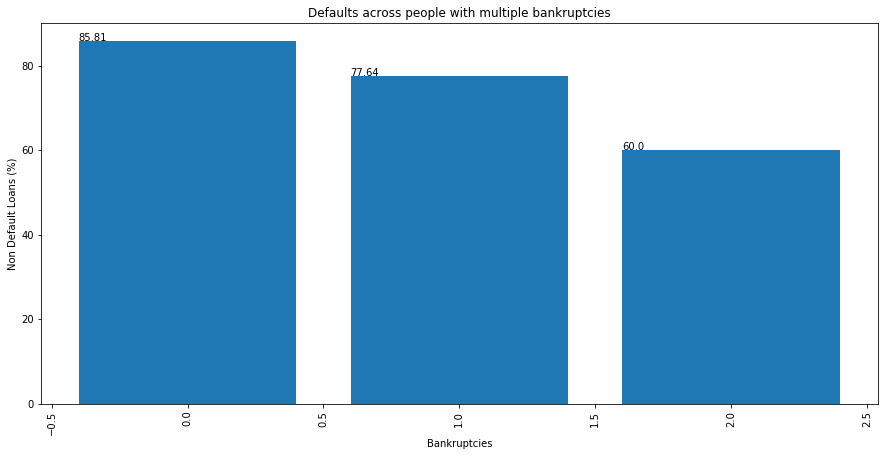

In [21]:
#Data anaysis for some categorical variables such as pub_rec_bankruptcies 

df_master_grp = df_master.groupby("pub_rec_bankruptcies")
x_val = df_master["pub_rec_bankruptcies"].unique()
x_val.sort()

y_val = round(df_master_grp["loan_status"].sum() / df_master_grp["loan_status"].count() * 100,2)

plot_bar_cust (x_val[:-1] ,y_val,'Non Default Loans (%)' \
               ,'Defaults across people with multiple bankruptcies' \
               ,'Bankruptcies',90)

### Loan default rates increase as the number of bankruptcies increase.

In [22]:
# Binning the categorical contineous data - 'int_rate'
int_rate_bins = [0, 2 ,4, 6, 8, 10, 12, 14, 16, 18,20,22,24,26]
bin_labels = ['< 2','< 4','<6','< 8','< 10','< 12','< 14','< 16','< 18','< 20','< 22','< 24','< 26']
#df_master['int_rate_binned'] = pd.cut(df_master['int_rate'], bins=int_rate_bins ,labels=bin_labels)

#df_master_grp = df_master.groupby("int_rate_binned")

#y_val = round((df_master_grp["loan_status"].count() - df_master_grp["loan_status"].sum()) / df_master_grp["loan_status"].count()* 100,2)

#plot_bar_cust (bin_labels ,y_val,'Non Default Loans (%)' \
#               ,'Defaults across different interest rate' \
#               ,'Interst Rate')

### There is not much variation in the default rates across different interest rates 

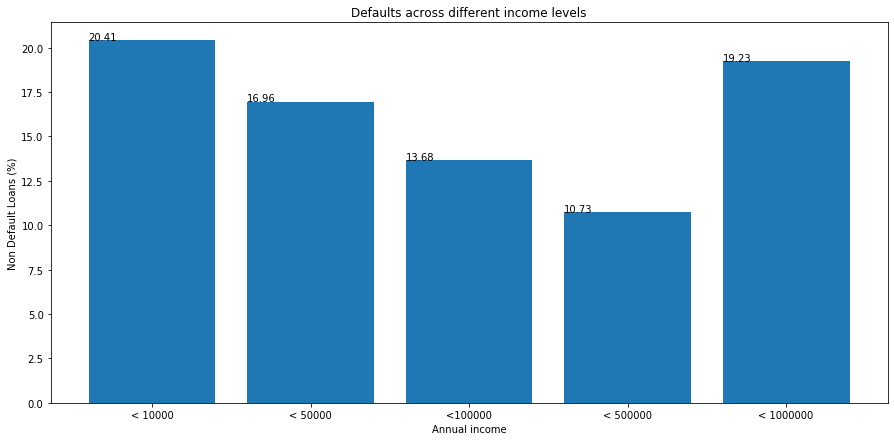

In [30]:
# Binning the categorical contineous data - 'annual_inc'
annual_inc_bins = [0, 10000 ,50000, 100000, 500000 ,1000000]
bin_labels = ['< 10000','< 50000','<100000','< 500000','< 1000000']
df_master['annual_inc_binned'] = pd.cut(df_master['annual_inc'], bins=annual_inc_bins ,labels=bin_labels)

df_master_grp = df_master.groupby("annual_inc_binned")

y_val = round((df_master_grp["loan_status"].count() - df_master_grp["loan_status"].sum()) / df_master_grp["loan_status"].count()*100,2)

plot_bar_cust (bin_labels ,y_val,'Non Default Loans (%)' \
               ,'Defaults across different income levels' \
               ,'Annual income')

#### There is no impact of the annual income on the default rate.

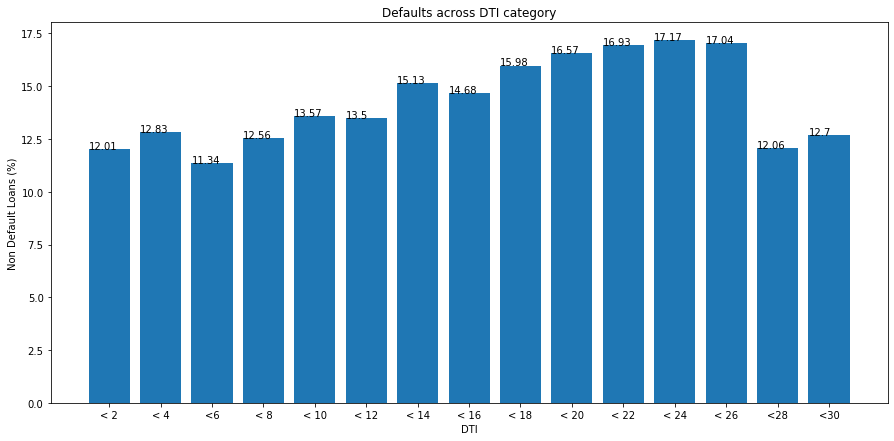

In [29]:
# Binning the categorical contineous data - 'dti'
dti_bins = [0, 2 ,4, 6, 8, 10, 12, 14, 16, 18,20,22,24,26,28,30]
bin_labels = ['< 2','< 4','<6','< 8','< 10','< 12','< 14','< 16','< 18','< 20','< 22','< 24','< 26','<28','<30']

df_master['dti_binned'] = pd.cut(df_master['dti'], bins=dti_bins , \
                                        labels=bin_labels)

df_master_grp = df_master.groupby("dti_binned")

y_val = round((df_master_grp["loan_status"].count() - df_master_grp["loan_status"].sum()) / df_master_grp["loan_status"].count()*100,2)

plot_bar_cust (bin_labels ,y_val,'Non Default Loans (%)' \
               ,'Defaults across DTI category' \
               ,'DTI')

#### There is no impact of DTI on the default rate. 

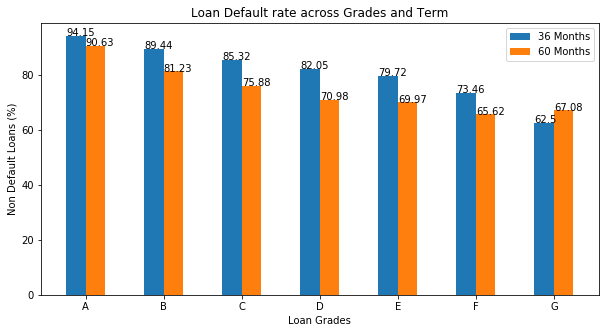

In [25]:
#bivariate analysis - Impact of term across grades, term and default rates

df_master_grp = df_master.groupby(["grade","term"])
df_master_grp1 = df_master.groupby(["grade","term"],as_index=False)
x_val = df_master["grade"].unique()
x_val.sort()

#create new df
df_36 = df_master[df_master['term'].str.strip() == '36 months']
df_60 = df_master[df_master['term'].str.strip() == '60 months']

df_36_grp = df_36.groupby("grade")
df_60_grp = df_60.groupby("grade")

y_val36 = round(df_36_grp["loan_status"].sum() / df_36_grp["loan_status"].count()*100,2)
y_val60 = round(df_60_grp["loan_status"].sum() / df_60_grp["loan_status"].count()*100,2)

x_pos = list(range(len(y_val36))) 
width = 0.25 
fig, term = plt.subplots(figsize=(10,5))
bars36 = plt.bar( x_pos, y_val36, align='center', width=width ,alpha=1)
bars60 = plt.bar( [p + width for p in x_pos], y_val60, width=width ,align='center', alpha=1)

plt.ylabel('Non Default Loans (%)')
plt.xlabel('Loan Grades')
plt.title('Loan Default rate across Grades and Term')

term.set_xticks([p + 0.5 * width for p in x_pos])

term.set_xticklabels(x_val)

for bar in bars36:
    ht = bar.get_height()
    plt.text(bar.get_x(), ht + .005, ht,rotation=0)

for bar in bars60:
    ht = bar.get_height()
    plt.text(bar.get_x(), ht + .005, ht,rotation=0)

plt.legend(['36 Months', '60 Months'], loc='upper right')
plt.show()

### Loan default is lower for 36 months loan across all the grades except 'G'

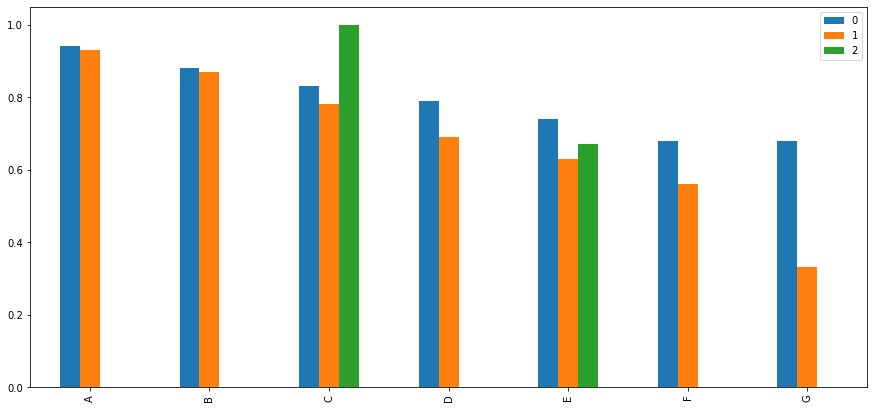

In [26]:
#bivariate analysis - Impact of Bankrupcies across grades and default rates

df_master_grp = df_master.groupby(["grade","pub_rec_bankruptcies"])
df_master_grp1 = df_master.groupby(["grade","pub_rec_bankruptcies"],as_index=False)
x_val = df_master["grade"].unique()
x_val.sort()

#create new df
df_0 = df_master[df_master['pub_rec_bankruptcies'] == 0]
df_1 = df_master[df_master['pub_rec_bankruptcies'] == 1]
df_2 = df_master[df_master['pub_rec_bankruptcies'] == 2]

df_0_grp = df_0.groupby("grade")
df_1_grp = df_1.groupby("grade")
df_2_grp = df_2.groupby("grade")

y_val0 = round(df_0_grp["loan_status"].sum() / df_0_grp["loan_status"].count(),2)
y_val1 = round(df_1_grp["loan_status"].sum() / df_1_grp["loan_status"].count(),2)
y_val2 = round(df_2_grp["loan_status"].sum() / df_2_grp["loan_status"].count(),2)


df = pd.concat([y_val0.rename(0) ,y_val1.rename(1), y_val2.rename(2)], axis=1 ,sort=True)

df.plot.bar()

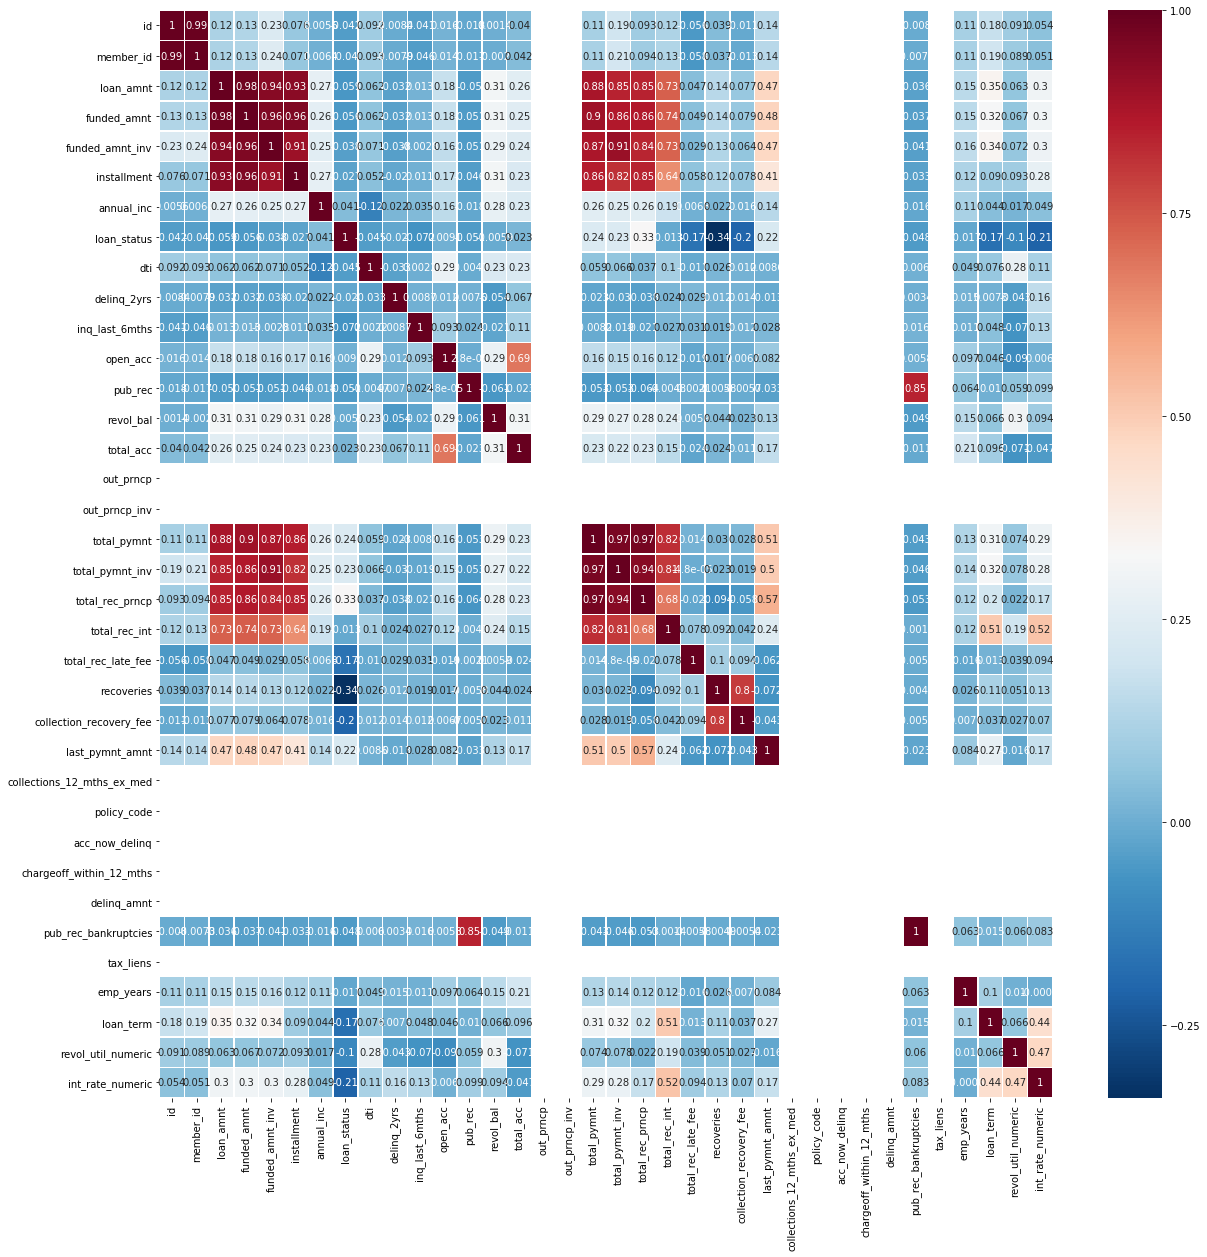

In [27]:
df_master_corr = df_master.corr(method='pearson')

rcParams['figure.figsize'] = 20, 20
import seaborn as sb
sb.heatmap(df_master_corr, \
            xticklabels=df_master_corr.columns, \
            yticklabels=df_master_corr.columns, \
            cmap='RdBu_r', \
            annot=True, \
            linewidth=0.5)